(examples:measurements_2d)=
# Topological skeleton analysis in 2D

In [1]:
import napari_toska as nts
from skimage.morphology import skeletonize
from skimage.data import binary_blobs
from skimage.measure import label
import numpy as np
import napari

In [2]:
labels = label(binary_blobs(rng=0))

In [3]:
labeled_skeletons = nts.generate_labeled_skeletonization(labels)
print('Number of skeletons: ', labeled_skeletons.max())

Number of skeletons:  15


## Generating skeletons

before diving into actually parsing skeletons and measureing their parameters, let's first summarize a bit of semantics:

- **Labeled skeleton**: An image of skeletonized object, where every skeleton carries a unique label.
- **Parsed skeletons**: Postprocessed, labeled skeletons with the pixel value indicating whether a pixel is an endpoint, a branching point or a branch. It can, and at this point should be, derived for a single skeleton.
- **Labeled branches**: A skeleton where every branch within a single skeleton carries a unique label.

### Intermediate results
- **Adjacency matrix**: A matrix of size $n \times m$, where $n$ is the number of nodes and $m$ is the number of edges. The matrix is binary, with $1$ indicating that the node is connected to the edge.
- **Spine image**: The spine of a skeleton is defined as the longest simple path between two endpoints of a single skeleton. The image retains the branch labels of edges contributing to the spine.

### Network analysis
- **Coarse grained**: A dataframe with features for each skeleton, where each row is a skeleton and each column is a feature.
- **Fine grained**: A dataframe with features for each branch and node, where each row is a branch or node and each column is a feature. This is done *per skeleton*.

## Parse skeletons

In [4]:
parsed_skeletons_single = nts.parse_single_skeleton(labeled_skeletons, label=2, neighborhood='n8')
parsed_skeletons_all = nts.parse_all_skeletons(labeled_skeletons, neighborhood='n8')

In [5]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


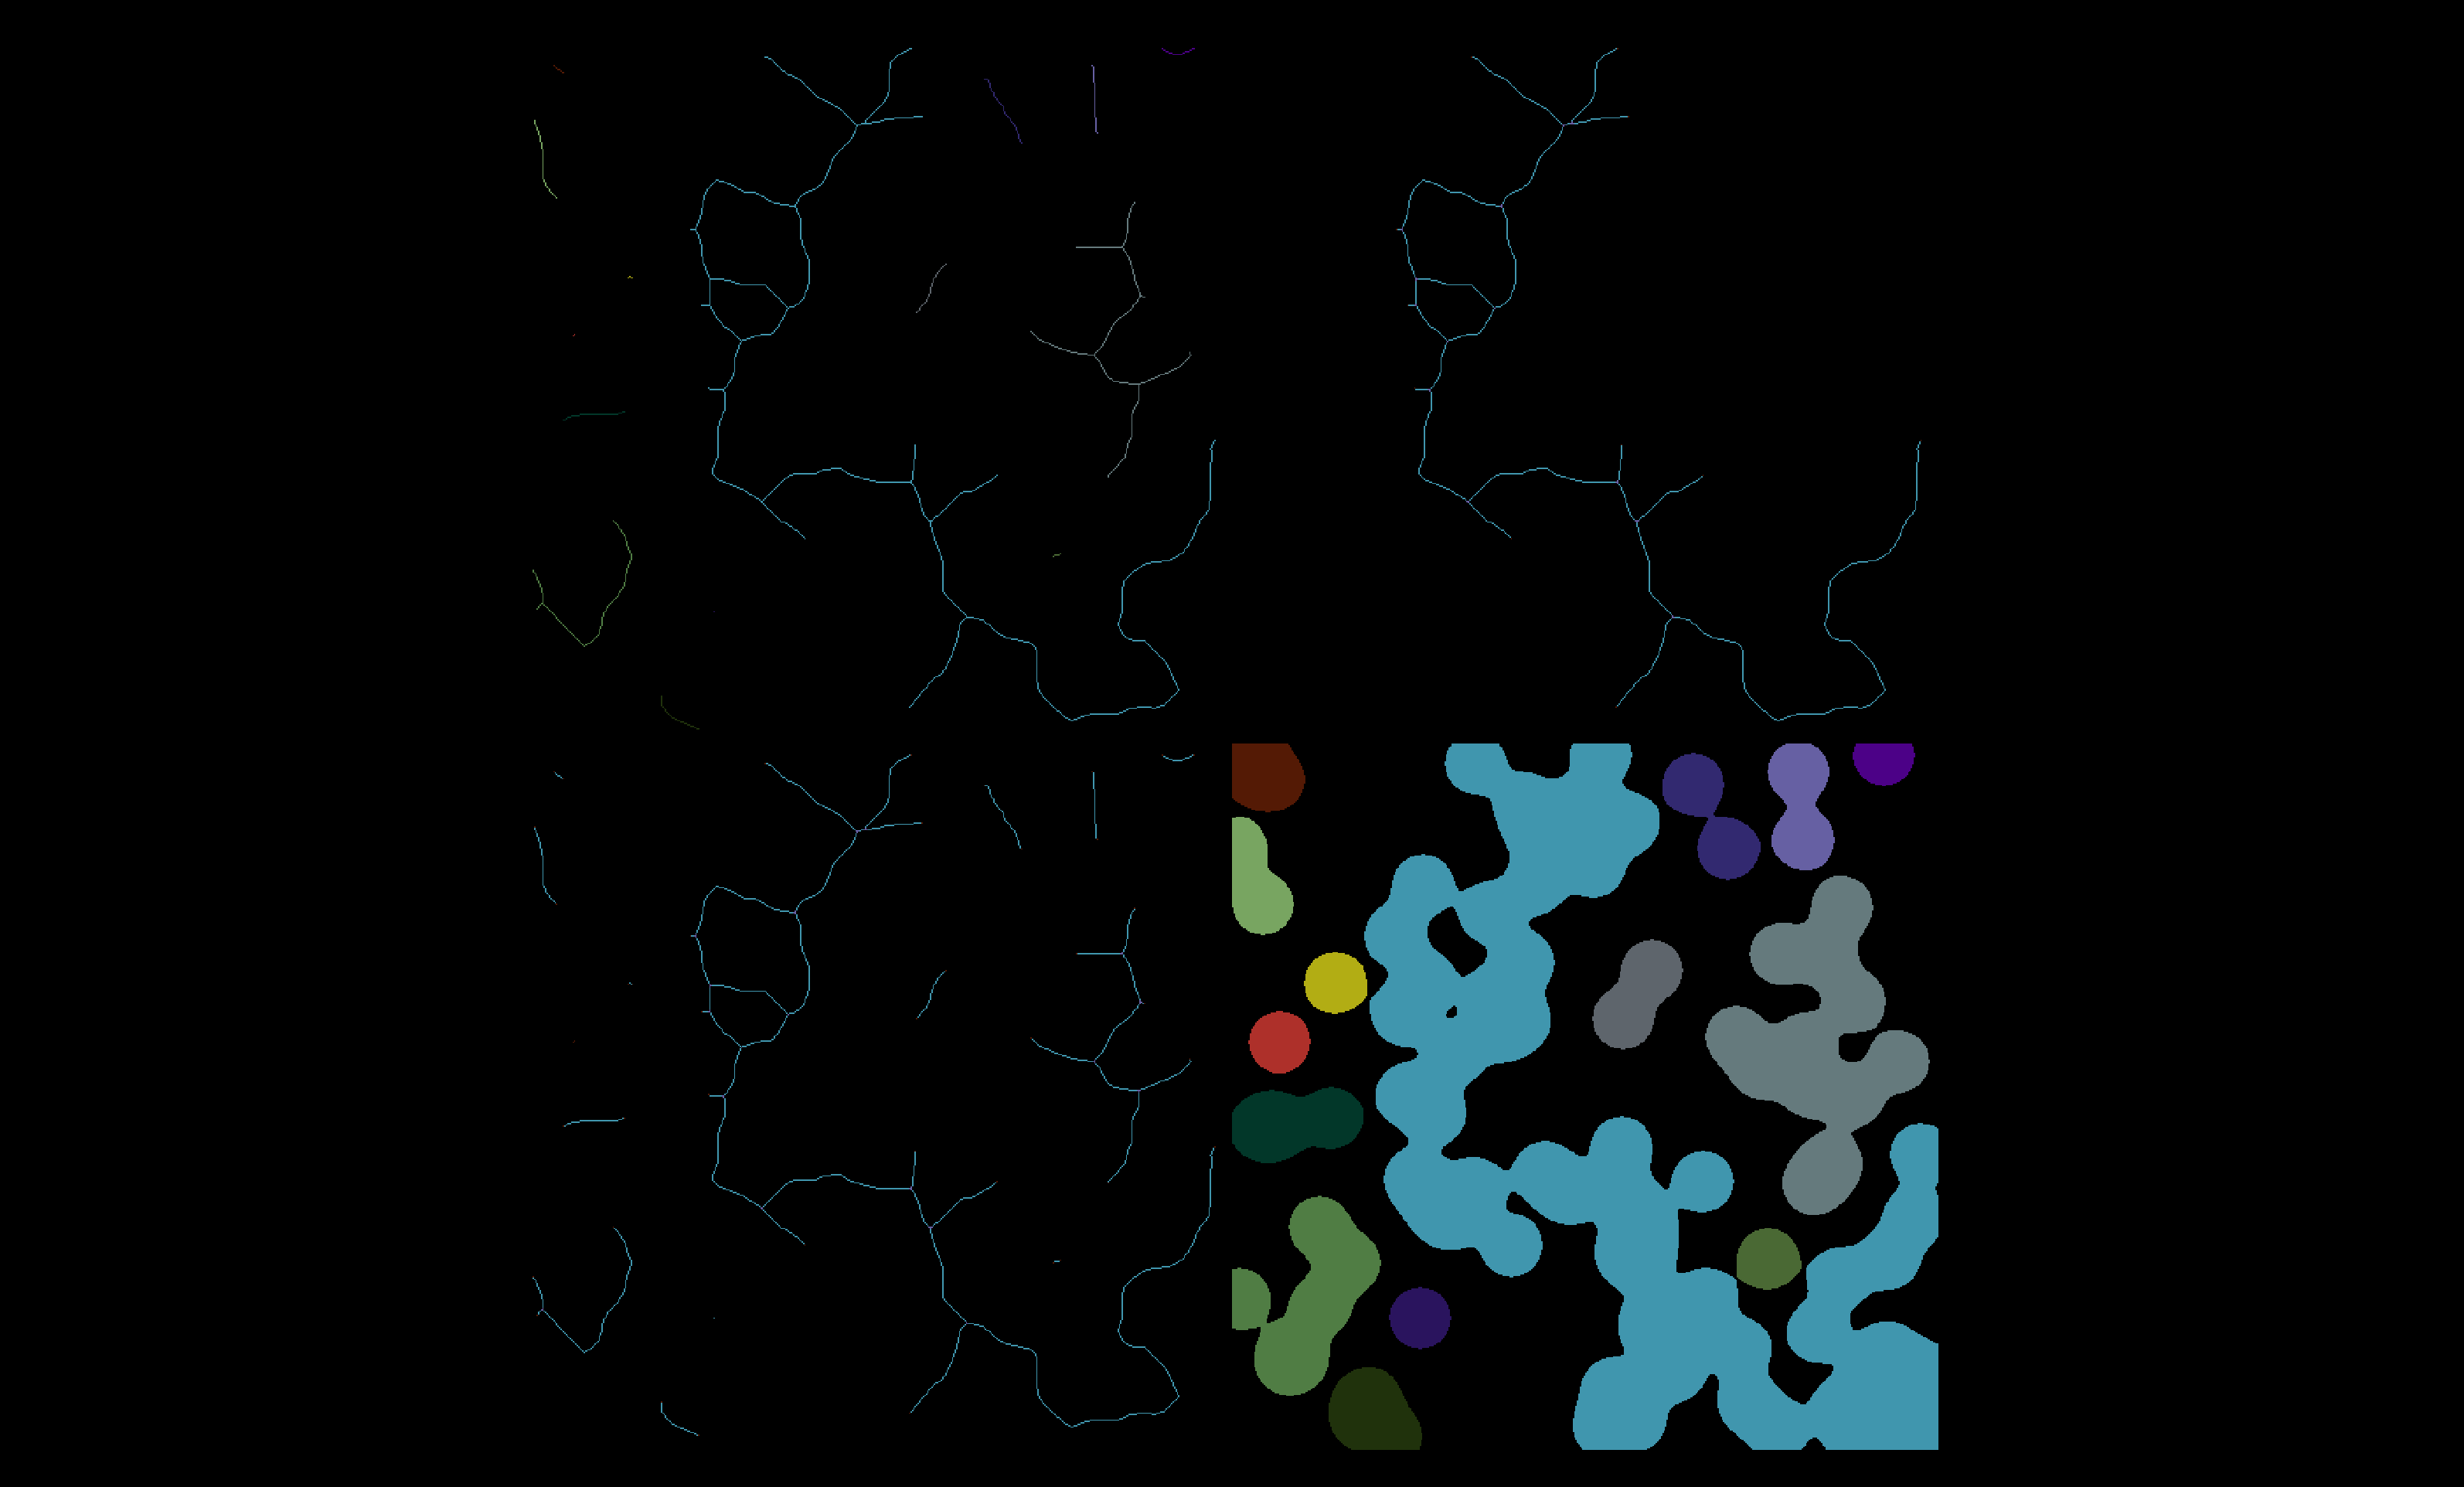

In [6]:
viewer.add_labels(labels, name='labels')
viewer.add_labels(parsed_skeletons_all)
viewer.add_labels(parsed_skeletons_single)
viewer.add_labels(labeled_skeletons)
viewer.grid.enabled = True
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [7]:
adjacency_matrix = nts.create_adjacency_matrix(parsed_skeletons_single, neighborhood='n8')
graph = nts.convert_adjacency_matrix_to_graph(adjacency_matrix)

In [8]:
labeled_branches_single = nts.label_branches(parsed_skeletons_single, labeled_skeletons, neighborhood='n8')
viewer.add_labels(labeled_branches_single)

<Labels layer 'labeled_branches_single' at 0x1e1a0316d00>

In [9]:
spine = nts.create_spine_image(adjacency_matrix=adjacency_matrix,
                               labeled_branches=labeled_branches_single)
viewer.add_labels(spine)

<Labels layer 'spine' at 0x1e1a0738a30>

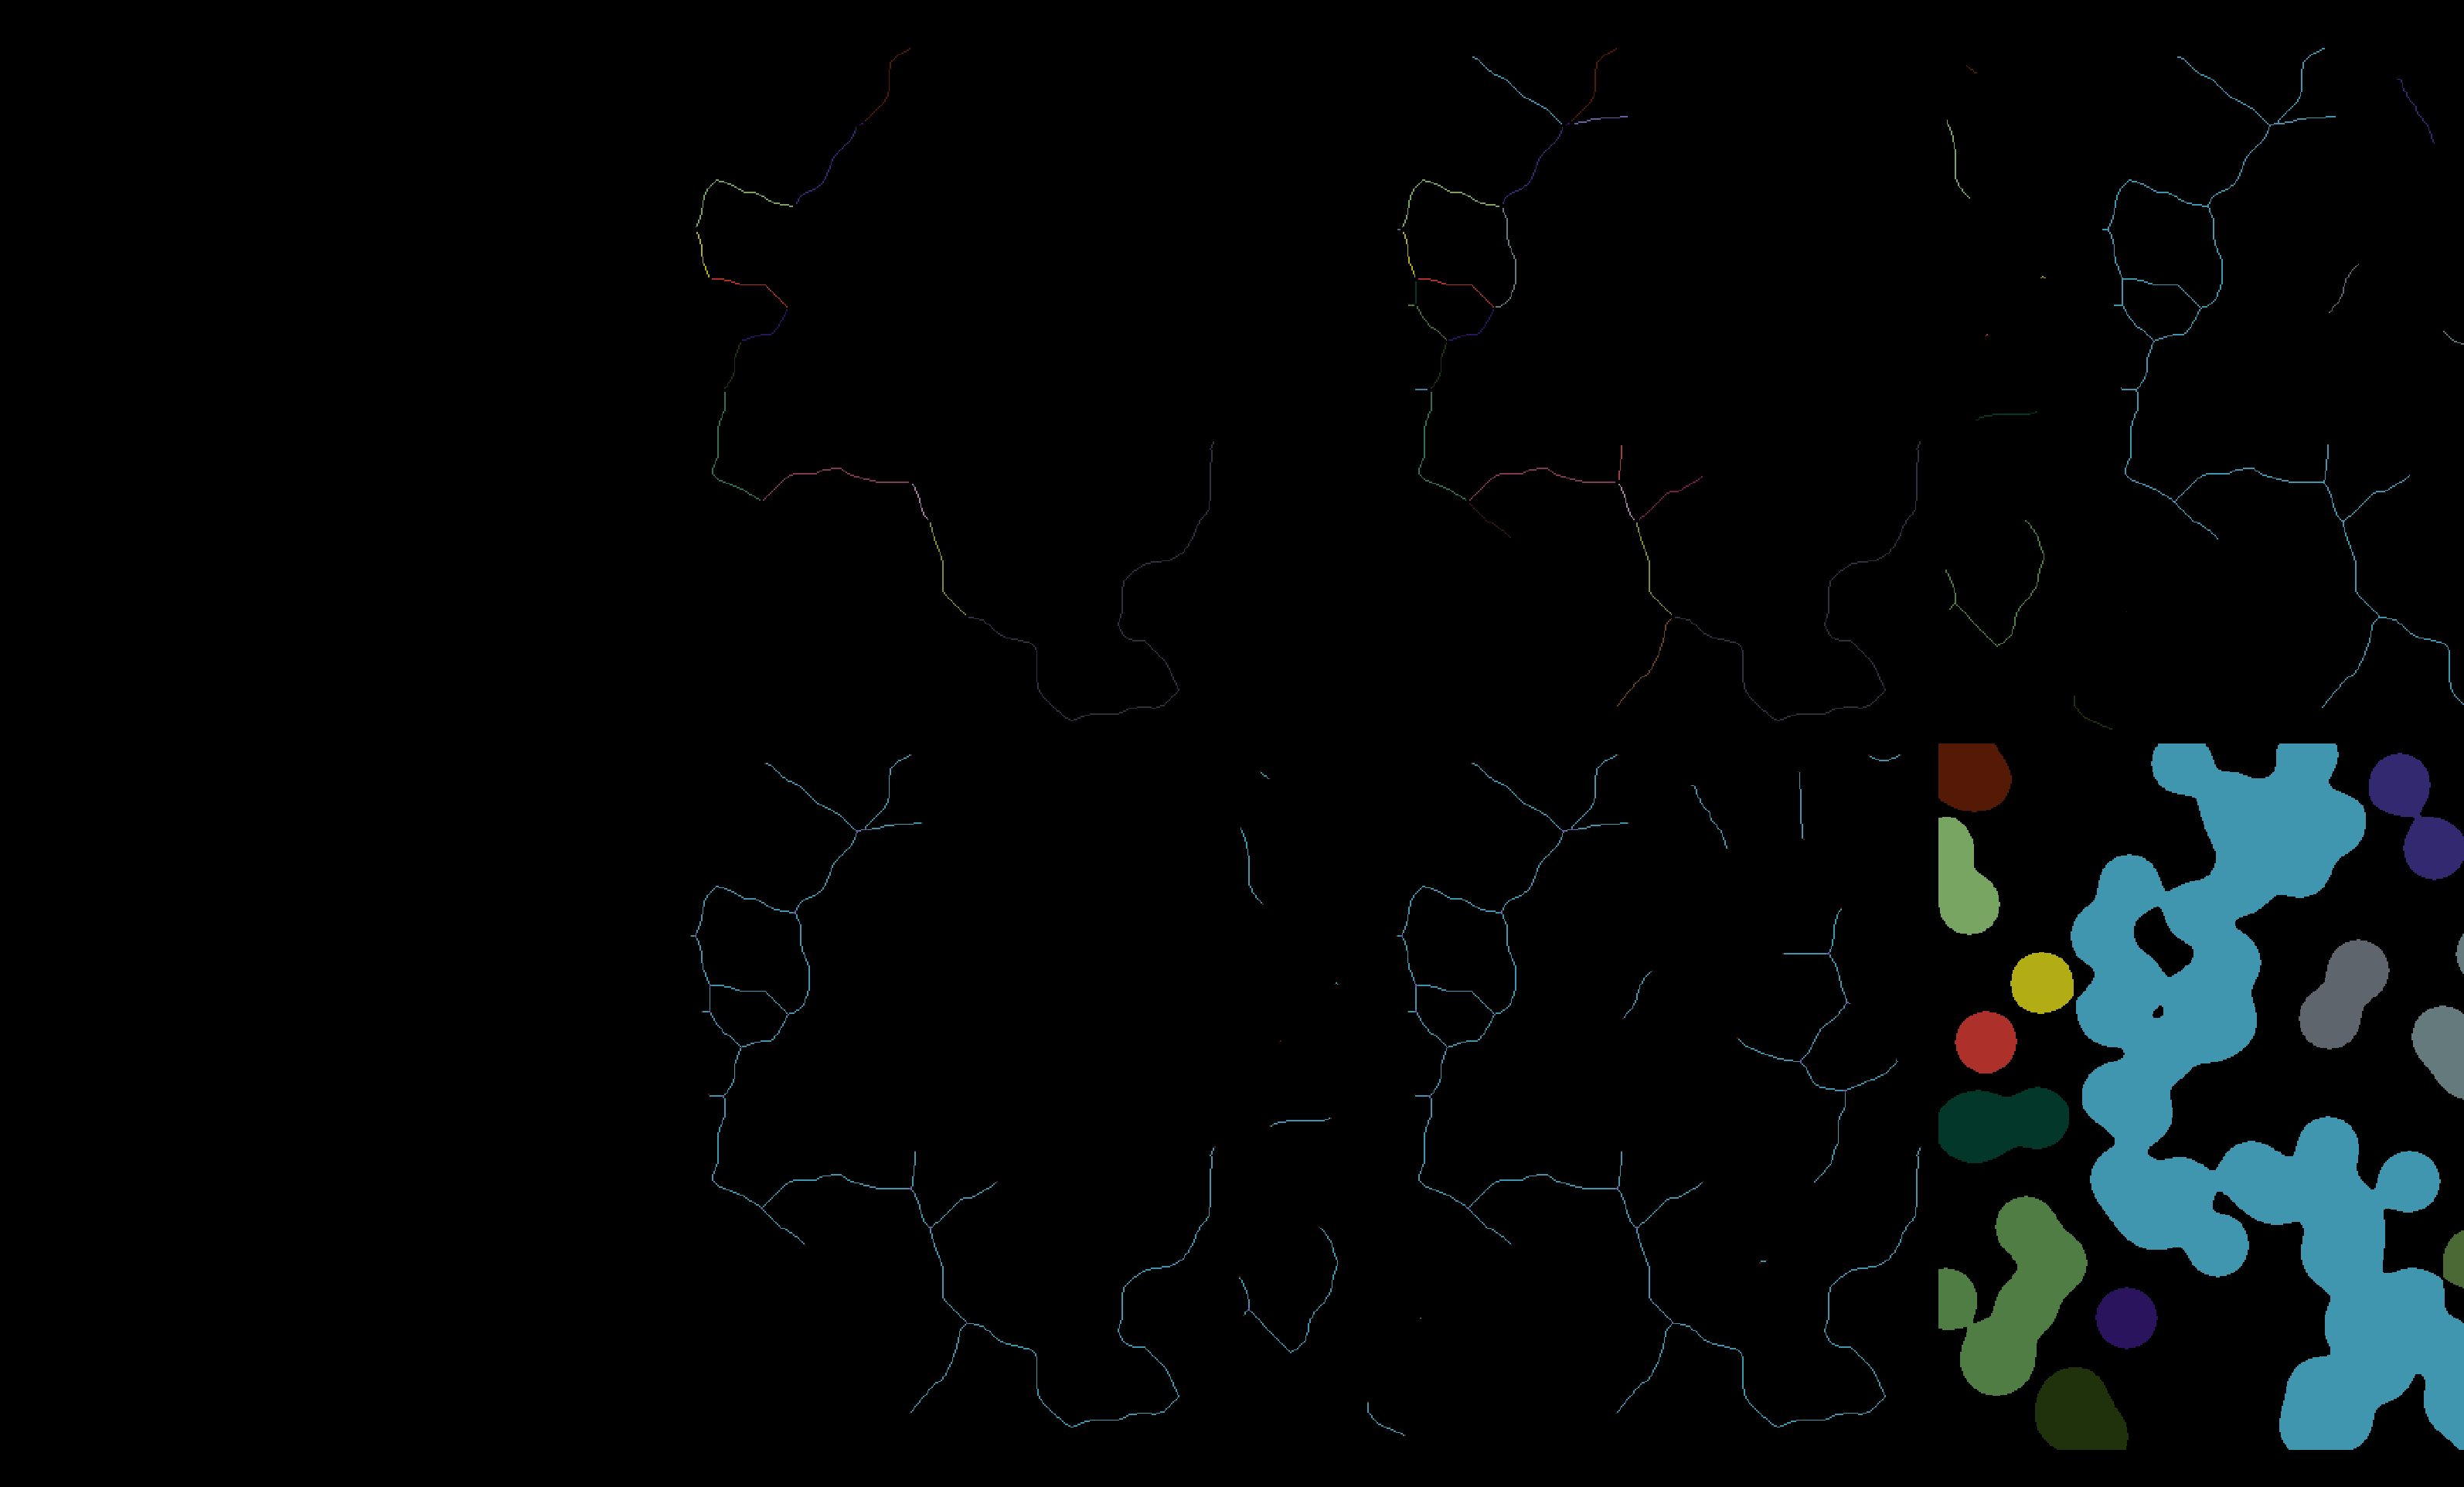

In [10]:
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Measurements

We now get some measurements (see above) for a single skeleton.

In [11]:
# spine length (in image), number of pixels in spine
parsed_skeletons_single = nts.parse_single_skeleton(labeled_skeletons, label=1, neighborhood='n8')
branch_labels = nts.label_branches(parsed_skeletons_single, 1*(parsed_skeletons_single > 0),
                                    neighborhood='n8')

In [12]:
adjacency_matrix = nts.create_adjacency_matrix(parsed_skeletons_single, neighborhood='n8')
spine_image = nts.create_spine_image(adjacency_matrix, branch_labels)

In [13]:
image_spine_length = nts._measurements.calculate_spine_length(spine_image)

In [14]:
features = nts.analyze_skeletons(
    labeled_skeletons=labeled_skeletons,
    parsed_skeletons=parsed_skeletons_all)
features

,skeleton_id,n_endpoints,n_branch_points,n_nodes,n_branches,n_cycle_basis,n_possible_undirected_cycles,label
0,1,2,0,2,1,0,0,1
0,2,11,13,24,25,2,3,2
0,3,2,0,2,1,0,0,3
0,4,2,0,2,1,0,0,4
0,5,2,0,2,1,0,0,5
0,6,2,0,2,1,0,0,6
0,7,6,4,10,9,0,0,7
0,8,2,0,2,1,0,0,8
0,9,2,0,2,1,0,0,9
0,10,0,0,0,0,0,0,10


In [15]:
nts.analyze_single_skeleton_network(parsed_skeletons_single, neighborhood='n8')

,label,component_type,degree,weight,node_1,node_2,node_labels
0,1,node,1.0,NaN,NaN,NaN,0.0
1,2,node,1.0,NaN,NaN,NaN,1.0
2,3,edge,NaN,1.0,0.0,1.0,NaN


In [16]:
nts.calculate_branch_lengths(labeled_branches_single)

,label,branch_length
0,1,41.012193
1,2,69.296465
2,3,8.485281
3,4,2.828427
4,5,53.740115
5,6,49.497475
6,7,28.284271
7,8,1.414214
8,9,12.727922
9,10,29.698485
